# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [263]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import random as rn
from keras import backend as K
import tensorflow as tf
import cv2
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

We set the random seed so that the results don't vary drastically.

In [264]:
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)

In [265]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [266]:
# Parameter Initialization
rows = 120 # X dimension
cols = 120 # Y Dimension
channels = 3 # RGB channel
frames= 30  # Total frames to be picked up

In [267]:
# Enable this testing code for creating list of images for lesser frames 
#img_idx = [1,3,5,7,10,12, 13,15,17,20,22,24, 25,27,29]
#len(img_idx)

In [268]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [1,3,5,7,10,12, 13,15,17,20,22,24, 25,27,29] #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]  # Enable this line after basic model testing with lesser frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        #print('No of batches', num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),rows,cols,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print ('Batch no ',batch, 'Folder no',folder)
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    filename = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    #print('Reading file:', filename)
                    image = cv2.imread(filename, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    h, w, c = image.shape
                    #print('Old Image Shape:', image.shape)
                    #cv2_imshow(image) # plt.imshow(image)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if ((h != rows) | (w != cols)):
                       image_crop  = image[0:120,20:140]
                       image_resize =  cv2.resize(image, (rows,cols), interpolation = cv2.INTER_AREA)
                       image_norm = image_resize
                       #image_norm = image_resize - np.min(image_resize)/np.max(image_resize) - np.min(image_resize)
                       #print('New Image Shape:', image_norm.shape)
                       #cv2_imshow(image_norm)
                    else:
                       #image_norm = image - np.min(image)/np.max(image) - np.min(image)
                       image_norm = image

                    batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
          batch_size = len(folder_list) - (batch_size*num_batches)
          batch_data = np.zeros((batch_size,len(img_idx),rows,cols,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(batch_size): # iterate over the batch_size
            #print ('Batch no ',batch, 'Folder no',folder)
            imgs = os.listdir(source_path +'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
               filename = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
               #print('Reading file:', filename)
               image = cv2.imread(filename, cv2.IMREAD_COLOR)
               image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
               h, w, c = image.shape
               #print('Old Image Shape:', image.shape)
               #cv2_imshow(image)
               #crop the images and resize them. Note that the images are of 2 different shape 
               #and the conv3D will throw error if the inputs in a batch have different shapes

               if ((h != rows) | (w != cols)):
                  image_crop  = image[0:120,20:140]
                  image_resize =  cv2.resize(image, (rows,cols), interpolation = cv2.INTER_AREA)
                  image_norm = image_resize
                  #image_norm = image_resize - np.min(image_resize)/np.max(image_resize) - np.min(image_resize)
                  #print('New Image Shape:', image_norm.shape)
                  #cv2_imshow(image_norm)
               else:
                   image_norm = image
                   #image_norm = image - np.min(image)/np.max(image) - np.min(image)

               batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
               batch_data[folder,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
               batch_data[folder,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels for remaining data
      

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [269]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [270]:
# Code to be enabled for testing only
#train_doc = open('./gdrive/My Drive/aAIML/06-Neural Networks/data/Copy of train.csv').readlines()
#train_doc = open('./gdrive/My Drive/aAIML/06-Neural Networks/data/train.csv').readlines()
#val_doc = open('./gdrive/My Drive/aAIML//06-Neural Networks/data/val.csv').readlines()

In [271]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [272]:
#Code to be enabled for testing only
#getData('./gdrive/My Drive/aAIML/06-Neural Networks/data/train', train_doc, batch_size)
#train_path = './gdrive/My Drive/aAIML/06-Neural Networks/data/train'
#val_path = './gdrive/My Drive/aAIML/06-Neural Networks/data/val'

## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [273]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam
import os
import shutil
import numpy as np
import glob   
import keras.backend as K
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras import optimizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import scipy.misc

### Conv3D

#### Model

In [274]:
featuremap = [8,16,32,64]
dense = [256,128,5]
classes = 5

input_shape=(frames,rows,cols,channels)

modelConv3D = Sequential()
modelConv3D.add(Conv3D(featuremap[0], kernel_size=(3,3,3), input_shape=input_shape, padding='same', name="conv1"))
modelConv3D.add(BatchNormalization())
modelConv3D.add(Activation('relu'))

modelConv3D.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D.add(Conv3D(featuremap[1], kernel_size=(3,3,3), padding='same',name="conv2"))
modelConv3D.add(BatchNormalization())
modelConv3D.add(Activation('relu'))

modelConv3D.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D.add(Conv3D(featuremap[2], kernel_size=(1,3,3), padding='same',name="conv3"))
modelConv3D.add(BatchNormalization())
modelConv3D.add(Activation('relu'))
#modelConv3D.add(Dropout(0.25))

modelConv3D.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D.add(Conv3D(featuremap[3], kernel_size=(1,3,3), padding='same',name="conv4"))
modelConv3D.add(BatchNormalization())
modelConv3D.add(Activation('relu'))
modelConv3D.add(Dropout(0.25))

modelConv3D.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D.add(Flatten())

modelConv3D.add(Dense(dense[0], activation='relu'))
modelConv3D.add(Dropout(0.25))

modelConv3D.add(Dense(dense[1], activation='relu'))
modelConv3D.add(Dropout(0.25))

#softmax layer
modelConv3D.add(Dense(dense[2], activation='softmax'))

The next step is to `compile` the model. 
The `summary` of the model shows the total number of parameters you have to train.

In [275]:
optimiser = Adam()
modelConv3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_67 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_41 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_68 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_42 (Activation)   (None, 15, 60, 60, 16)    0         
__________

#### Checkpoint
We will keep saving the best model's weights at models/best_models.hdf5. Model weights are usually saved in hdf5 files.

Saving the best model is done using the callback functionality that comes with ModelCheckpoint. 
Specify the filepath where the model weights are to be saved, 
monitor='val_auc' specifies that you are choosing the best model based on validation accuracy, 
save_best_only=True saves only the best weights, 
mode='max' specifies that the validation accuracy is to be maximised.

In [276]:
model_name = 'Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)



#### Training (Fit) 

Fit the Base Model (Using Batch-Wise Data Generation)
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [277]:
# Set Epochs and batch size
num_epochs = 60
print ('# epochs =', num_epochs)
batch_size = 90
print ('# Batch Size =', batch_size)

# epochs = 60
# Batch Size = 90


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [278]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
When we use data generators, we use the `model.fit_generator` method rather than the usual `model.fit`.

In [279]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [280]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.35, patience=2, cooldown=1, verbose=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, cooldown=1, verbose=1,mode='auto',min_delta=0.0001)
callbacks_list = [checkpoint, LR]

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [281]:
history = modelConv3D.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=2, initial_epoch=0)

Source path =  Project_data/val ; batch size = 90
Source path =  Project_data/train ; batch size = 90
Epoch 1/60
8/8 [==============================] - 50s 6s/step - loss: 2.8904 - categorical_accuracy: 0.2218 - val_loss: 1.6657 - val_categorical_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 1.66567, saving model to Conv3D_2020-03-2814_54_12.024742/model-00001-2.96365-0.22021-1.66567-0.28000.h5
Epoch 2/60
8/8 [==============================] - 10s 1s/step - loss: 1.6751 - categorical_accuracy: 0.3750 - val_loss: 1.5236 - val_categorical_accuracy: 0.3500

Epoch 00002: val_loss improved from 1.66567 to 1.52364, saving model to Conv3D_2020-03-2814_54_12.024742/model-00002-1.67513-0.37500-1.52364-0.35000.h5
Epoch 3/60
8/8 [==============================] - 18s 2s/step - loss: 1.5987 - categorical_accuracy: 0.3447 - val_loss: 2.0066 - val_categorical_accuracy: 0.1500

Epoch 00003: val_loss did not improve from 1.52364
Epoch 4/60
8/8 [==============================] - 9s 1s/st


Epoch 00030: val_loss did not improve from 1.05566
Epoch 31/60
8/8 [==============================] - 2s 251ms/step - loss: 1.1854 - categorical_accuracy: 0.4583 - val_loss: 1.1490 - val_categorical_accuracy: 0.6500

Epoch 00031: val_loss did not improve from 1.05566

Epoch 00031: ReduceLROnPlateau reducing learning rate to 7.881563206524333e-08.
Epoch 32/60
8/8 [==============================] - 2s 304ms/step - loss: 1.7153 - categorical_accuracy: 0.2917 - val_loss: 1.3166 - val_categorical_accuracy: 0.3500

Epoch 00032: val_loss did not improve from 1.05566
Epoch 33/60
8/8 [==============================] - 2s 230ms/step - loss: 1.2164 - categorical_accuracy: 0.5000 - val_loss: 1.1221 - val_categorical_accuracy: 0.6000

Epoch 00033: val_loss did not improve from 1.05566

Epoch 00033: ReduceLROnPlateau reducing learning rate to 2.758547097414521e-08.
Epoch 34/60
8/8 [==============================] - 2s 208ms/step - loss: 1.3726 - categorical_accuracy: 0.5000 - val_loss: 1.0971 - val

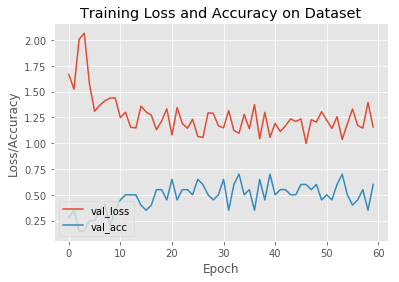

In [282]:
N = num_epochs
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Conv2D + RNN

In [283]:
# Conv2D + RNN

featuremap = [8,16,32,64,128]
dense = [128,64,5]
classes = 5

input_shape=(frames,rows,cols,channels)

modelConv2DRNN = Sequential()

modelConv2DRNN.add(TimeDistributed(Conv2D(featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


modelConv2DRNN.add(TimeDistributed(Conv2D(featuremap[1], (3,3),padding='same', activation='relu')))
modelConv2DRNN.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
modelConv2DRNN.add(TimeDistributed(BatchNormalization()))


modelConv2DRNN.add(TimeDistributed(Conv2D(featuremap[2], (3,3),padding='same', activation='relu')))
modelConv2DRNN.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
modelConv2DRNN.add(TimeDistributed(BatchNormalization()))

modelConv2DRNN.add(TimeDistributed(Conv2D(featuremap[3], (2,2),padding='same', activation='relu')))
modelConv2DRNN.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
modelConv2DRNN.add(TimeDistributed(BatchNormalization()))
modelConv2DRNN.add(Dropout(0.25))

modelConv2DRNN.add(TimeDistributed(Conv2D(featuremap[4], (2,2),padding='same', activation='relu')))
modelConv2DRNN.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
modelConv2DRNN.add(TimeDistributed(BatchNormalization()))
#modelConv2DRNN.add(Dropout(0.25))

modelConv2DRNN.add(TimeDistributed(Flatten()))

modelConv2DRNN.add(Dense(dense[0], activation='relu'))
modelConv2DRNN.add(Dropout(0.25))
modelConv2DRNN.add(Dense(dense[1], activation='relu'))
modelConv2DRNN.add(Dropout(0.25))

#modelConv2DRNN.add(GRU(64, return_sequences=True))

modelConv2DRNN.add(GRU(128, return_sequences=True))

modelConv2DRNN.add(GRU(64, return_sequences=False))

modelConv2DRNN.add(Dense(classes, activation='softmax'))

The next step is to `compile` the model. 
The `summary` of the model shows the total number of parameters you have to train.

In [284]:
optimiser = Adam()
modelConv2DRNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv2DRNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_118 (TimeDi (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_119 (TimeDi (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_120 (TimeDi (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_121 (TimeDi (None, 30, 30, 30, 16)    64        
_________________________________________________________________
time_distributed_122 (TimeDi (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_123 (TimeDi (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_124 (TimeDi (None, 30, 15, 15, 32)    128       
__________

#### Checkpoint
We will keep saving the best model's weights at models/best_models.hdf5. Model weights are usually saved in hdf5 files.

Saving the best model is done using the callback functionality that comes with ModelCheckpoint. 
Specify the filepath where the model weights are to be saved, 
monitor='val_auc' specifies that you are choosing the best model based on validation accuracy, 
save_best_only=True saves only the best weights, 
mode='max' specifies that the validation accuracy is to be maximised.

In [285]:
model_name = 'Conv2DRNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)



#### Training (Fit) 

Fit the Base Model (Using Batch-Wise Data Generation)
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [286]:
# Set Epochs and batch size
num_epochs = 60
print ('# epochs =', num_epochs)
batch_size = 90
print ('# Batch Size =', batch_size)

# epochs = 60
# Batch Size = 90


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [287]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
When we use data generators, we use the `model.fit_generator` method rather than the usual `model.fit`.

In [288]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [289]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.35, patience=3, cooldown=1, verbose=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, cooldown=1, verbose=1,mode='auto',min_delta=0.0001)
callbacks_list = [checkpoint, LR]

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [290]:
history = modelConv2DRNN.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 90
Source path =  Project_data/train Epoch 1/60
; batch size = 90
8/8 [==============================] - 47s 6s/step - loss: 1.3722 - categorical_accuracy: 0.3756 - val_loss: 1.1175 - val_categorical_accuracy: 0.6200

Epoch 00001: val_loss improved from inf to 1.11750, saving model to Conv2DRNN_2020-03-2814_54_12.024742/model-00001-1.39707-0.36048-1.11750-0.62000.h5
Epoch 2/60
8/8 [==============================] - 7s 935ms/step - loss: 1.0788 - categorical_accuracy: 0.5530 - val_loss: 1.1529 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 1.11750
Epoch 3/60
8/8 [==============================] - 18s 2s/step - loss: 0.9414 - categorical_accuracy: 0.6212 - val_loss: 1.1938 - val_categorical_accuracy: 0.5500

Epoch 00003: val_loss did not improve from 1.11750
Epoch 4/60
8/8 [==============================] - 11s 1s/step - loss: 1.0396 - categorical_accuracy: 0.6537 - val_loss: 0.8548 - val_categorical_accuracy:

8/8 [==============================] - 2s 221ms/step - loss: 1.0432 - categorical_accuracy: 0.6250 - val_loss: 0.7409 - val_categorical_accuracy: 0.7500

Epoch 00034: val_loss did not improve from 0.70138
Epoch 35/60
8/8 [==============================] - 2s 219ms/step - loss: 0.8056 - categorical_accuracy: 0.7083 - val_loss: 1.0993 - val_categorical_accuracy: 0.4500

Epoch 00035: val_loss did not improve from 0.70138
Epoch 36/60
8/8 [==============================] - 2s 303ms/step - loss: 1.1640 - categorical_accuracy: 0.5833 - val_loss: 1.1016 - val_categorical_accuracy: 0.7500

Epoch 00036: val_loss did not improve from 0.70138

Epoch 00036: ReduceLROnPlateau reducing learning rate to 7.881563206524333e-08.
Epoch 37/60
8/8 [==============================] - 2s 234ms/step - loss: 0.8959 - categorical_accuracy: 0.7500 - val_loss: 1.1461 - val_categorical_accuracy: 0.5000

Epoch 00037: val_loss did not improve from 0.70138
Epoch 38/60
8/8 [==============================] - 2s 288ms/ste

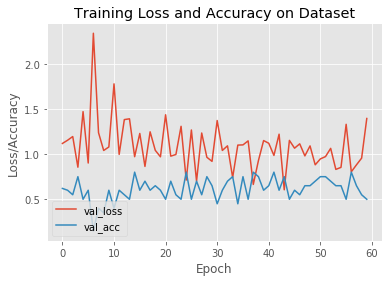

In [291]:
N = num_epochs
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

------------- End of Program --------------